A notebook for visualizing the various space filling curves implemented for the thesis. Also compares the two methods for generalizing the sfc's to arbitrary images, and the hamiltonian path generation for those curves.

We start by importing the `space_filling_curves.py` module

In [1]:
import sys
sys.path.append('..')

from src.curves.space_filling_curves import *
import matplotlib.pyplot as plt
import numpy as np

/home/remco/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Visualise all the curves of order 1 to 3 on the unit square

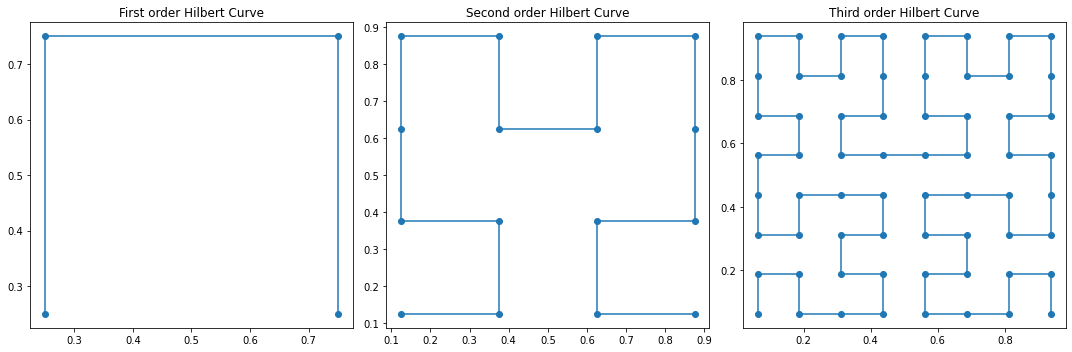

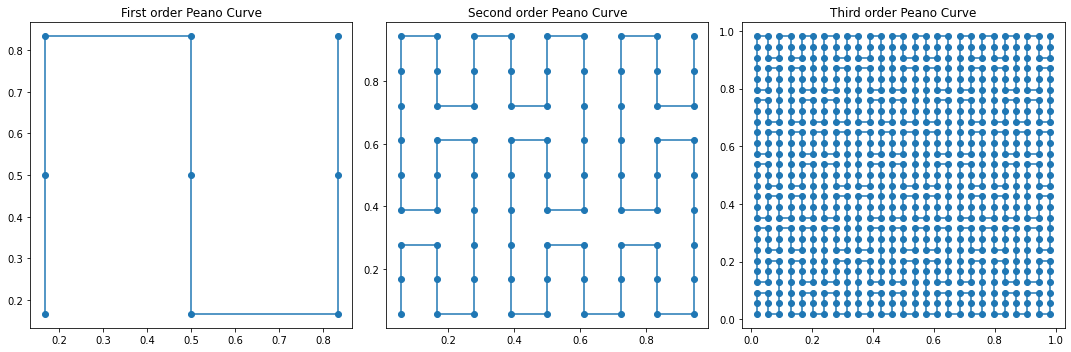

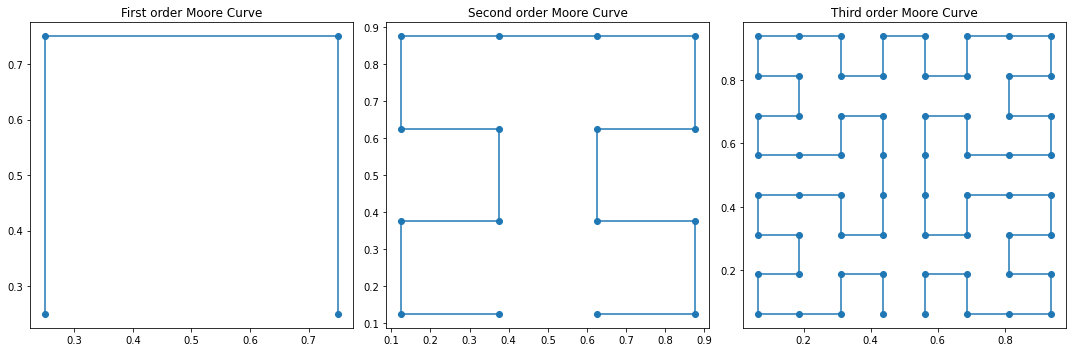

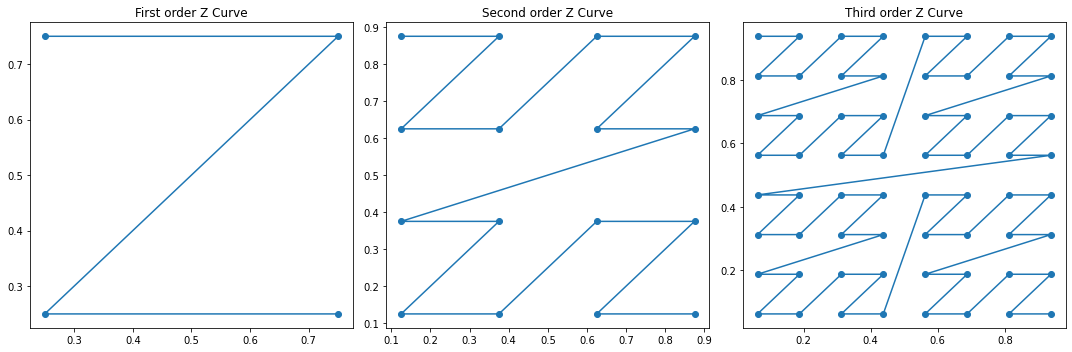

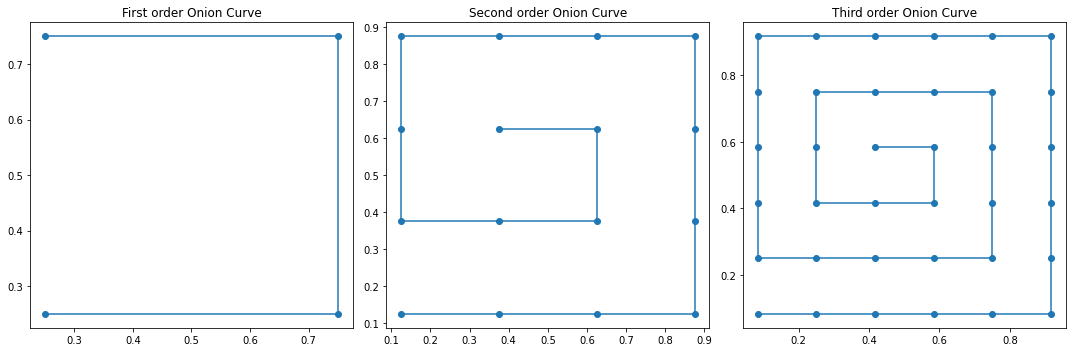

In [2]:
def visualise_sfc(sfc, orders):
    _, ax = plt.subplots(1, len(orders), figsize=(15, 5))
    for i, o in enumerate(orders):
        curve = sfc(o, 1)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        prefix = "First" if o == 1 else "Second" if o == 2 else "Third"
        ax[i].set_title(f"{prefix} order {name}")

    plt.tight_layout()
    plt.show()

order = [1, 2, 3]
visualise_sfc(hilbert_curve, order)
visualise_sfc(peano_curve, order)
visualise_sfc(moore_curve, order)
visualise_sfc(z_curve, order)
visualise_sfc(onion_curve, order)

One problem with these curves is that they are only defined on images with a power of 2 size (power of 3 in the case of the peano curve). One solution is to generate a bigger sfc and downsample it to the size of the image. This is done by generating a sfc of size $2^n$ and then downsampling it to the size of the image. Below is an example of generating sfc on a 7x7 image, which is not a grid of $2^n$.

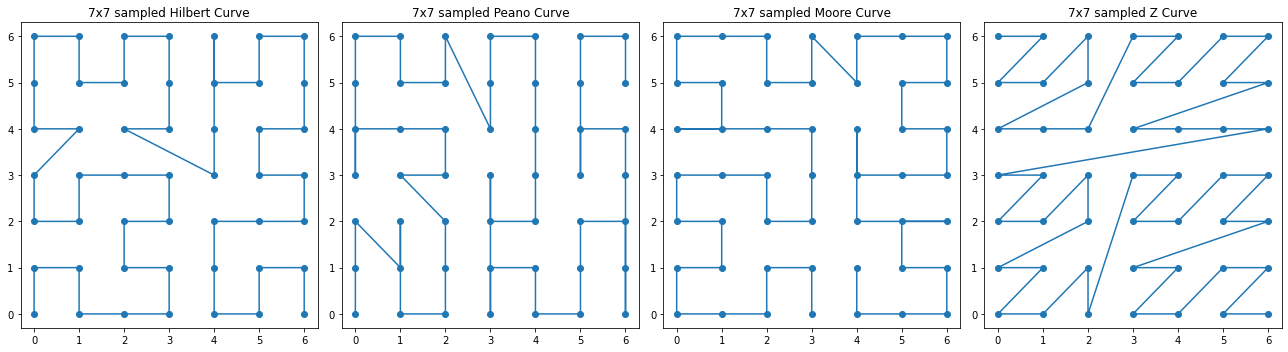

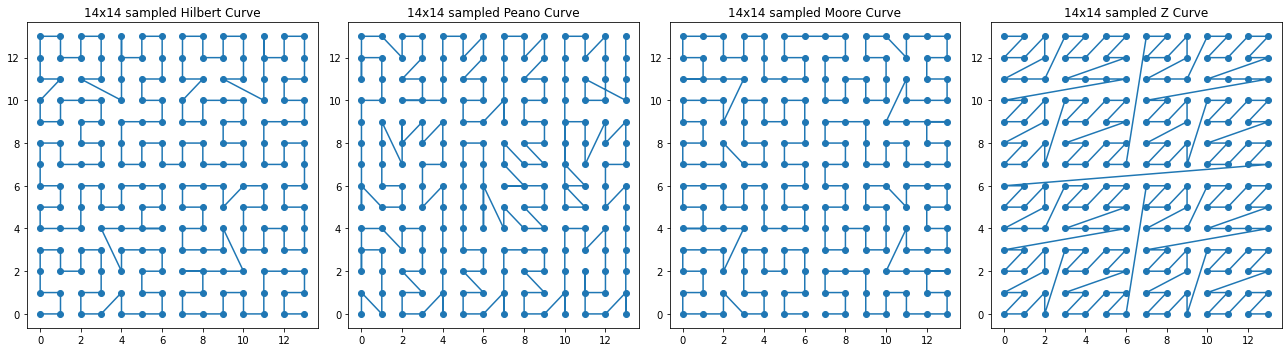

In [3]:
def visualise_sampled_sfc_combined(sfc_list, height, width):
    _, ax = plt.subplots(1, len(sfc_list), figsize=(18, 5))
    for i, sfc in enumerate(sfc_list):
        curve = sample_sfc(sfc, width, height)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        ax[i].set_title(f"{height}x{width} sampled {name}")

    plt.tight_layout()
    plt.show()

height = 7
width = 7
sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
visualise_sampled_sfc_combined(sfc_list, height, width)
visualise_sampled_sfc_combined(sfc_list, height * 2, width * 2)


Another way to do this is to generate a sfc on a padded square grid of sufficient size and then pruning points that fall outside the desired domain.

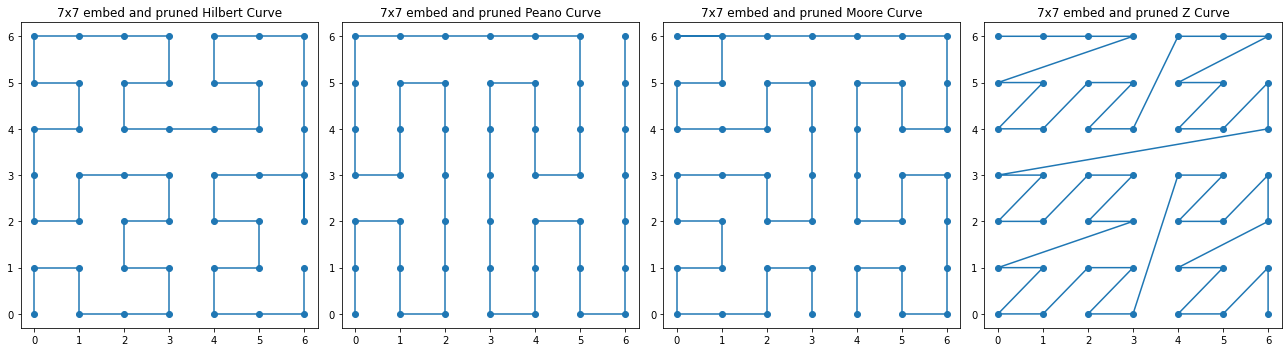

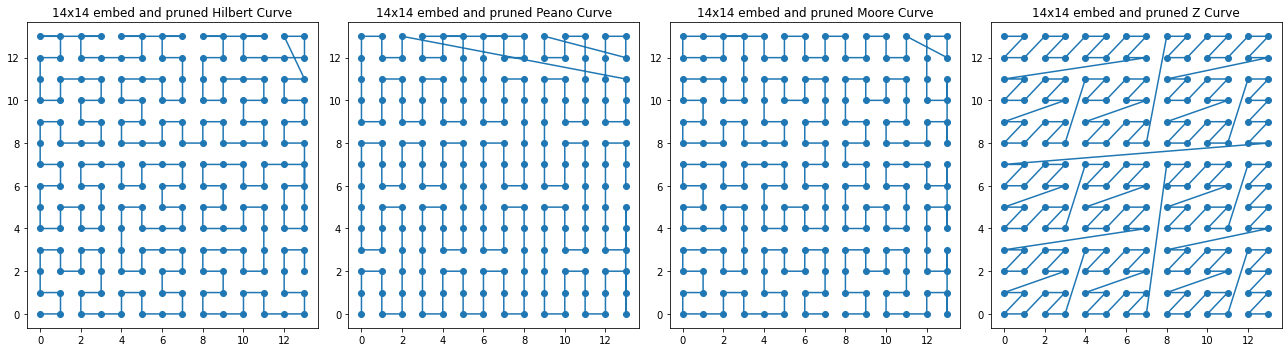

In [4]:
def visualise_embed_and_pruned_sfc_combined(sfc_list, height, width):
    _, ax = plt.subplots(1, len(sfc_list), figsize=(18, 5))
    for i, sfc in enumerate(sfc_list):
        curve = embed_and_prune_sfc(sfc, width, height)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        ax[i].set_title(f"{height}x{width} embed and pruned {name}")

    plt.tight_layout()
    plt.show()

sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
visualise_embed_and_pruned_sfc_combined(sfc_list, height, width)
visualise_embed_and_pruned_sfc_combined(sfc_list, height * 2, width * 2)

One problem with both of these approaches is that they do not guarantee a Hamiltonian path. The Hamiltonian path is a path that visits every point in the grid exactly once. This is important for the sfc to be a valid space filling curve. Although this property isn't necessary for the use-end of this project, it is still a nice property to have. This is due to jumps being made in both methods, which is detrimental to locality. Below we use a function from the `space_filling_curves.py` module to to post-process the sampled/pruned sfc back to a Hamiltonian path.

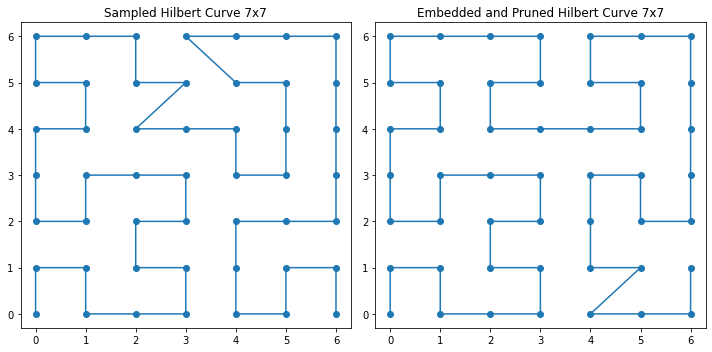

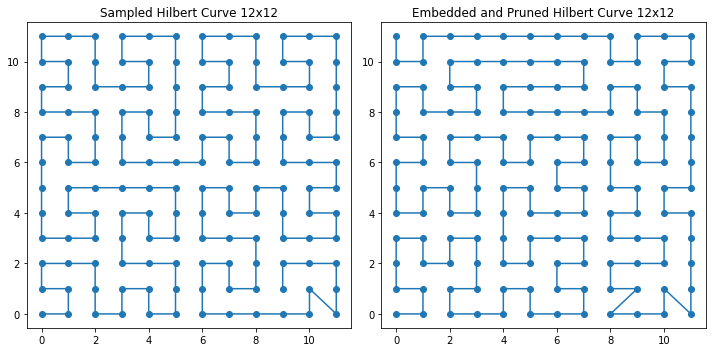

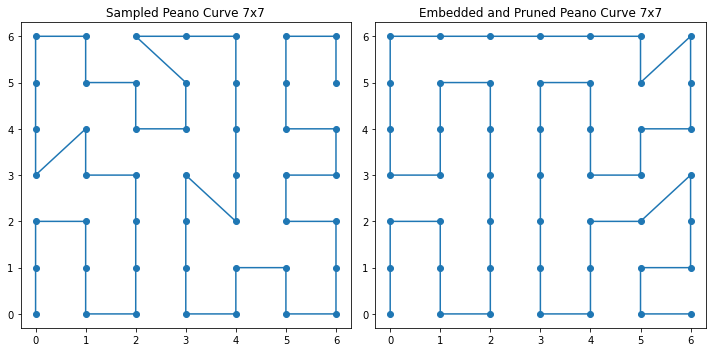

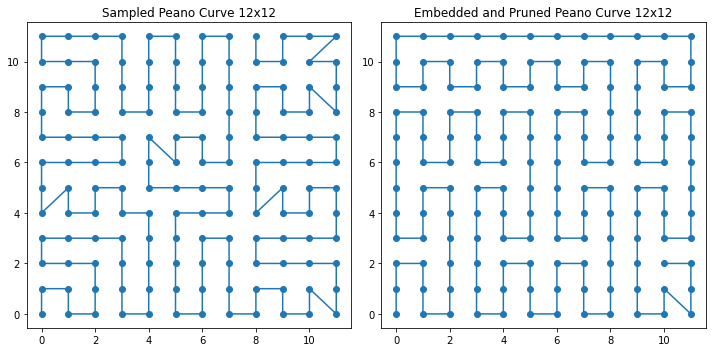

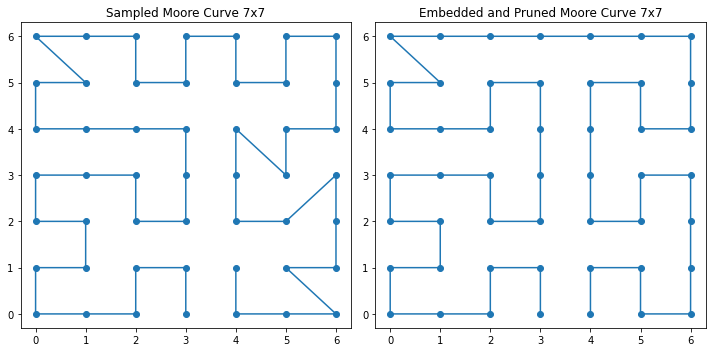

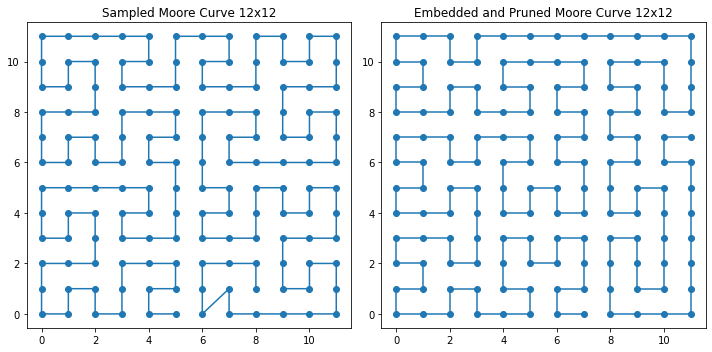

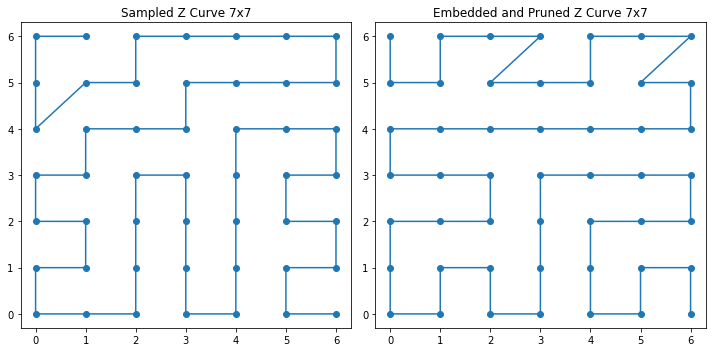

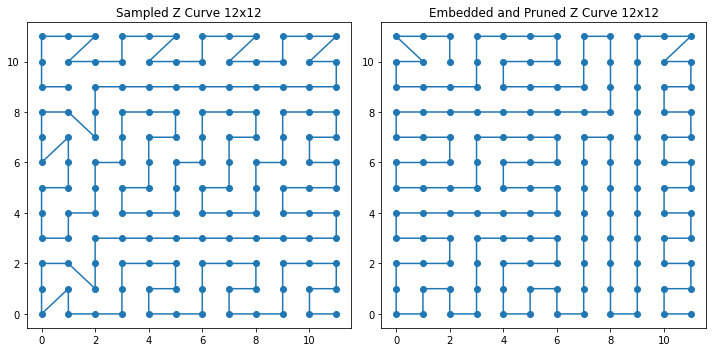

In [7]:
def visualise_hamiltonian_reconstruction(sfc, height, width):
    """
    Visualise the Hamiltonian reconstruction of a space-filling curve.
    Generates a plot of the reconstructed curve for both the sampled and
    the embedded and pruned versions next to each other.
    """
    _, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Sampled SFC
    sampled_curve = refine_curve_to_hamiltonian(sample_sfc(sfc, width, height), width, height)
    name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
    x_sampled, y_sampled = zip(*sampled_curve)  # unzip into x and y coordinates
    ax[0].plot(x_sampled, y_sampled, marker='o')
    ax[0].set_title(f"Sampled {name} {height}x{width}")

    # Embedded and Pruned SFC
    embedded_curve = refine_curve_to_hamiltonian(embed_and_prune_sfc(sfc, width, height), width, height)
    x_embedded, y_embedded = zip(*embedded_curve)  # unzip into x and y coordinates
    ax[1].plot(x_embedded, y_embedded, marker='o')
    ax[1].set_title(f"Embedded and Pruned {name} {height}x{width}")

    plt.tight_layout()
    plt.show()

sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
for sfc in sfc_list:
    visualise_hamiltonian_reconstruction(sfc, height, width)
    visualise_hamiltonian_reconstruction(sfc, 12, 12)